In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import font_manager
import os, glob
import json

# define project directories 
root = os.path.abspath(os.getcwd())

In [2]:
#read in charity data
cc_df = pd.read_csv("registered-charity_20220724.csv")
cc_ch = cc_df[~cc_df["companyNumber"].isna()]

C:\Users\LISA~1.HOR\AppData\Local\Temp/ipykernel_9532/2524972240.py:2: DtypeWarning: Columns (2,3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  cc_df = pd.read_csv("registered-charity_20220724.csv")


In [121]:
sic_section_names = {
    "A": "Agriculture (A)",
    "B": "Mining (B)",
    "C": "Manufacturing (C)",
    "D": "Electricity and Gas (D)", 
    "E": "Water and waste management (E)",
    "F": "Construction (F)",
    "G": "Retail (G)",
    "H": "Transportation (H)",
    "I": "Accommodation and food services (I)",
    "J": "Information and communication (J)",
    "K": "Finance and insurance (K)",
    "L": "Real estate (L)",
    "M": "Scientific and technical activities (M)",
    "N": "Administrative activities (N)",
    "O": "Public administration (O)",
    "P": "Education (P)",
    "Q": "Health and social work (Q)",
    "R": "Arts, entertainment and recreation (R)",
    "S": "Other service activities (S)",
    "T": "Households as employers (T)",
    "U": "Extraterritorial organisations (U)"
    }

In [13]:
sic_section_names_1 = {
    "A": "Agriculture, Forestry and Fishing",
    "B": "Mining and Quarrying",
    "C": "Manufacturing",
    "D": "Electricity, gas, steam supply", 
    "E": "Water supply, sewerage, waste management",
    "F": "Construction",
    "G": "Retail; motor vehicles repair",
    "H": "Transportation and storage",
    "I": "Accommodation and food services",
    "J": "Information and communication",
    "K": "Financial and insurance activities",
    "L": "Real estate activities",
    "M": "Professional, scientific and technical activities",
    "N": "Administrative activities",
    "O": "Public administration and defence",
    "P": "Education",
    "Q": "Human health and social work",
    "R": "Arts, entertainment and recreation",
    "S": "Other service activities",
    "T": "Activities of households as employers",
    "U": "Activities of extraterritorial organisations and bodies"
    }


In [3]:
f = open('codes.json') 
sic_dict = json.load(f) 

In [4]:
# read in gender pay gap data and merge files
all_files = glob.glob(os.path.join(root, "UK Gender Pay Gap Data*.csv"))

all_df = []
for f in all_files:
    df = pd.read_csv(f, sep=',')
    df['file'] = f.split('\\')[-1][-16:-4]
    df = pd.merge(df, cc_ch, left_on="CompanyNumber", right_on="companyNumber", how='left')
    all_df.append(df)
    
pay_df = pd.concat(all_df, ignore_index=True, sort=True)

# Explore

### SIC codes

In [122]:
#clean up SIC codes a bit
pay_df["SIC_clean"] = pay_df["SicCodes"].str.replace("1,", "").str.replace("\n", "")
pay_df["SIC_clean"] = pay_df["SIC_clean"].fillna("")
pay_df["SIC_clean"] = pay_df["SIC_clean"].str.split(",")
pay_df["SIC_count"] = pay_df["SIC_clean"].str.len()

#map against section and industry name from dictionary

section_all = []
name_all = []

for i in range(len(pay_df["SIC_clean"])):
    section = []
    name = []
    for k in range(len(pay_df["SIC_clean"][i])):
        try:
            section.append(sic_dict[pay_df["SIC_clean"][i][k]]["section"])
            name.append(sic_dict[pay_df["SIC_clean"][i][k]]["industry"])
        except KeyError:
            pass
    section_all.append(section)
    name_all.append(name)

#add to dataframe
pay_df["SIC_sections"] = section_all
pay_df["SIC_names"] = name_all

#select first one as the main SIC
pay_df["SIC_section"] = pay_df["SIC_sections"].str[0]
pay_df["SIC_name"] = pay_df["SIC_names"].str[0]

pay_df["SIC_section_name"] = pay_df["SIC_section"].map(sic_section_names)

In [73]:
#Tech specific codes
tech = [ "58290", "62011", "62012", "62020", "62030", "62090", "63110", "63120"]

for code in tech:
    pay_df.loc[pay_df["SicCodes"].str.contains(code, na=False), "Sector"] = "Tech"

In [34]:
_filter = (pay_df["file"] == "2021 to 2022") & (~pay_df["SIC_section"].isin(["S", "T", "U", "D", "L", "E"]))
pivot = pay_df[_filter].groupby(["file", "SIC_section_name"])[['DiffMeanHourlyPercent','DiffMedianHourlyPercent' ,
                                                           'DiffMeanBonusPercent', 'DiffMedianBonusPercent' ]].mean()
pivot

DiffMeanHourlyPercent  \
file         SIC_section_name                                                           
2021 to 2022 Accommodation and food services                                 8.065885   
             Administrative activities                                       9.804222   
             Arts, entertainment and recreation                             22.324107   
             Construction                                                   20.053169   
             Education                                                      16.049583   
             Financial and insurance activities                             24.949884   
             Human health and social work                                    9.910315   
             Information and communication                                  17.821158   
             Manufacturing                                                  10.689612   
             Professional, scientific and technical activities              18.184746   
             Public administration and defence                               6.425502   
             Retail; motor vehicles repair                                  14.039179   
             Transportation and storage                                      9.155467   

                                                                DiffMedianHourlyPercent  \
file         SIC_section_name                                                             
2021 to 2022 Accommodation and food services                                   4.581237   
             Administrative activities                                         8.432806   
             Arts, entertainment and recreation                                4.953571   
             Construction                                                     22.062324   
             Education                                                        23.590917   
             Financial and insurance activities                               22.209049   
             Human health and social work                                      5.023561   
             Information and communication                                    16.436128   
             Manufacturing                                                     8.451008   
             Professional, scientific and technical activities                15.465113   
             Public administration and defence                                 6.015462   
             Retail; motor vehicles repair                                     8.644728   
             Transportation and storage                                        8.912000   

                                                                DiffMeanBonusPercent  \
file         SIC_section_name                                                          
2021 to 2022 Accommodation and food services                               16.730532   
             Administrative activities                                     13.688840   
             Arts, entertainment and recreation                            24.597122   
             Construction                                                  16.675391   
             Education                                                     17.185397   
             Financial and insurance activities                            36.818029   
             Human health and social work                                  10.276732   
             Information and communication                                 27.239095   
             Manufacturing                                                 21.622801   
             Professional, scientific and technical activities             27.293185   
             Public administration and defence                              2.542986   
             Retail; motor vehicles repair                                 25.227536   
             Transportation and storage                                    16.738393   

                                         

In [31]:
_filter = (pay_df["file"] == "2021 to 2022") & (~pay_df["SIC_section"].isin(["S", "T", "U", "D", "L", "E"]))
pivot = pay_df[_filter].groupby(["file", "SIC_section_name"])[['DiffMeanHourlyPercent','DiffMedianHourlyPercent' ,
                                                           'DiffMeanBonusPercent', 'DiffMedianBonusPercent' ]].count()
pivot

DiffMeanHourlyPercent  \
file         SIC_section_name                                                           
2021 to 2022 Accommodation and food services                                      469   
             Administrative activities                                           1137   
             Arts, entertainment and recreation                                   224   
             Construction                                                         284   
             Education                                                           1200   
             Financial and insurance activities                                   431   
             Human health and social work                                         921   
             Information and communication                                        501   
             Manufacturing                                                       1290   
             Professional, scientific and technical activities                    708   
             Public administration and defence                                    498   
             Retail; motor vehicles repair                                        901   
             Transportation and storage                                           375   

                                                                DiffMedianHourlyPercent  \
file         SIC_section_name                                                             
2021 to 2022 Accommodation and food services                                        469   
             Administrative activities                                             1137   
             Arts, entertainment and recreation                                     224   
             Construction                                                           284   
             Education                                                             1200   
             Financial and insurance activities                                     431   
             Human health and social work                                           921   
             Information and communication                                          501   
             Manufacturing                                                         1290   
             Professional, scientific and technical activities                      708   
             Public administration and defence                                      498   
             Retail; motor vehicles repair                                          901   
             Transportation and storage                                             375   

                                                                DiffMeanBonusPercent  \
file         SIC_section_name                                                          
2021 to 2022 Accommodation and food services                                     357   
             Administrative activities                                           905   
             Arts, entertainment and recreation                                  139   
             Construction                                                        256   
             Education                                                           315   
             Financial and insurance activities                                  416   
             Human health and social work                                        563   
             Information and communication                                       486   
             Manufacturing                                                      1171   
             Professional, scientific and technical activities                   631   
             Public administration and defence                                   221   
             Retail; motor vehicles repair                                       828   
             Transportation and storage                                          336   

                                         

In [130]:
_filter = (pay_df["file"] == "2021 to 2022") & (~pay_df["SIC_section"].isin(["S", "T", "U", "D", "L", "E"]))
pivot = pay_df[_filter].groupby([ "SIC_section_name"])[[ 'FemaleLowerQuartile', 
                                                               'FemaleLowerMiddleQuartile',
                                                               'FemaleUpperMiddleQuartile',
                                                               'FemaleTopQuartile' ]].mean()
pivot = pivot.sort_values(by="FemaleTopQuartile", ascending=False)
pivot

,FemaleLowerQuartile,FemaleLowerMiddleQuartile,FemaleUpperMiddleQuartile,FemaleTopQuartile
SIC_section_name,,,,
Health and social work (Q),77.768681,78.037253,77.337692,72.278571
Education (P),79.766413,75.312098,69.788663,63.589509
Public administration (O),57.384553,56.384959,54.008537,48.978659
Accommodation and food services (I),54.476667,51.524444,49.656222,45.302000
Administrative activities (N),50.779216,46.686326,42.660073,37.892069
"Arts, entertainment and recreation (R)",45.900000,44.983886,42.202370,35.267299
Retail (G),47.181561,45.842986,41.152376,35.249434
Scientific and technical activities (M),53.150860,48.021347,42.424785,34.577364
Finance and insurance (K),57.276102,50.431090,41.544084,30.673782


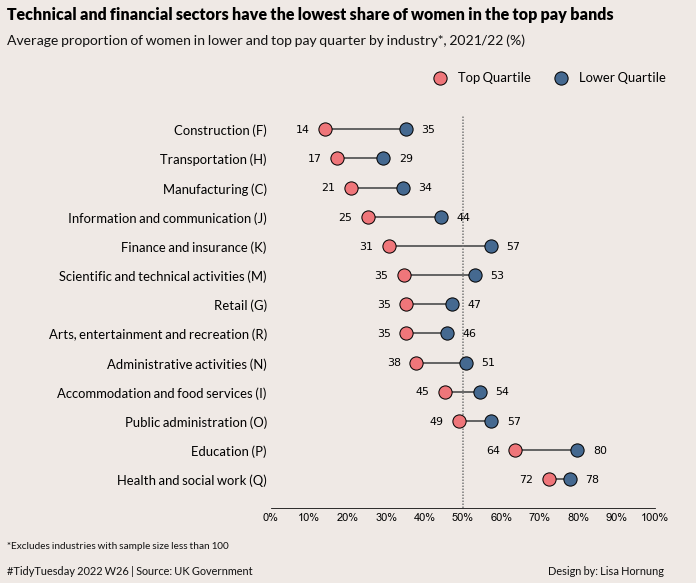

In [145]:
_filter = (pay_df["file"] == "2021 to 2022") & (~pay_df["SIC_section"].isin(["S", "T", "U", "D", "L", "E"]))
pivot = pay_df[_filter].groupby([ "SIC_section_name"])[[ 'FemaleLowerQuartile', 
                                                               'FemaleLowerMiddleQuartile',
                                                               'FemaleUpperMiddleQuartile',
                                                               'FemaleTopQuartile' ]].mean()
data = pivot.sort_values(by="FemaleTopQuartile", ascending=False)

## Charts
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Lato-Black.ttf')
label_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Lato-Regular.ttf')
colours = ["#ef767a","#456990", "#56cfe1"]

# =========
# Initialise Figure and define layout
fig, ax = plt.subplots(figsize=(6,7))
fig.set_facecolor("#efe9e5")
 
#make plot area transparent
plt.subplots_adjust(left=0.01, bottom=0.08, right=0.9, top=0.90, wspace=None, hspace=None)
plt.gca().patch.set_alpha(0) 

#remove grid
for pos in ['right', 'top',  'left']:
    ax.spines[pos].set_visible(False)

# ===========
# plot data                  
my_range=range(1,len(data.index)+1)

# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=data['FemaleLowerQuartile'], xmax=data['FemaleTopQuartile'],linewidth=2, 
           color='#666666', alpha=1, zorder=2)
plt.scatter(data['FemaleTopQuartile'], my_range, s=175, linewidth=1, edgecolors='black', 
            alpha=1, label='Top Quartile', zorder=3, color=colours[0])
plt.scatter(data['FemaleLowerQuartile'], my_range, s=175, linewidth=1, edgecolors='black', 
            alpha=1 , label='Lower Quartile', zorder=3, color=colours[1])

#==========
#annotation
plt.plot([50, 50], [0,len(data)+0.5],linestyle= (0,(1,1)), linewidth=1.5, color='#777777')

for i, values in enumerate(data['FemaleTopQuartile']):
    #if data.index[i].isin(['Information and communication (J)',])
    plt.text(values -4, my_range[i],'{:,.0f}'.format(values), fontsize = 11, weight = 'regular',  
             color='black', va='center', ha='right')
for i, values in enumerate(data['FemaleLowerQuartile']):   
    plt.text(values +4, my_range[i],'{:,.0f}'.format(values), fontsize = 11, weight = 'regular',  
             color='black', va='center', ha='left')

# ==========
#y-axis
plt.tick_params(axis='both', length = 0, color = "#444444")
plt.gca().set_ylim(ymin=0)
plt.yticks(my_range, data.index, fontsize=13, fontproperties=label_font)

#x-axis
plt.xticks(np.arange(0,110,10), fontfamily='Arial')
plt.tick_params(axis='x', labelsize=11)
plt.gca().set_xlim(xmin=0, xmax=100)
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:,.0f}%'.format(x)))

# ==========
#legend
L = ax.legend(ncol=2, frameon=False, loc='upper right',bbox_to_anchor=(1.05,1.08))
plt.setp(L.texts, fontfamily="Lato", fontsize=13)

# ==========
# Title and footer
plt.figtext(-0.6,1.05,'Technical and financial sectors have the lowest share of women in the top pay bands',
         fontsize = 16, weight = 'bold', fontproperties=title_font, color='black')
plt.figtext(-0.6,1, "Average proportion of women in lower and top pay quarter by industry*, 2021/22 (%)", 
            fontproperties=label_font,
            fontsize=14, ha='left',  color="#111111", fontfamily="Lato")

#footer
plt.figtext(-0.6,-0.0, "*Excludes industries with sample size less than 100",
            fontsize=10, ha='left', color="#111111", fontfamily="Lato")
plt.figtext(-0.6,-0.05, "#TidyTuesday 2022 W26 | Source: UK Government", fontsize=11,
            ha='left', color="#111111", fontfamily="Lato")
plt.figtext(0.98,-0.05, "Design by: Lisa Hornung            ",
            fontsize=11, ha='right', color="#111111", fontfamily="Lato")

# ==========
#save
plt.savefig("Women_share_top_low_pay_band_by_industry.png", bbox_inches="tight",pad_inches=0.2)

# Show the graph
plt.show()

In [123]:
pay_df["SIC_section_name"].unique()

array(['Education (P)', 'Retail (G)', 'Administrative activities (N)',
       'Arts, entertainment and recreation (R)',
       'Accommodation and food services (I)',
       'Health and social work (Q)', 'Manufacturing (C)',
       'Transportation (H)', 'Construction (F)',
       'Scientific and technical activities (M)', 'Real estate (L)',
       'Other service activities (S)', 'Finance and insurance (K)', nan,
       'Extraterritorial organisations (U)',
       'Information and communication (J)', 'Public administration (O)',
       'Water and waste management (E)', 'Electricity and Gas (D)',
       'Households as employers (T)'], dtype=object)

In [16]:
pivot = pay_df.groupby(["file", "SIC_section_name"])[[ 'FemaleTopQuartile']].mean()
pivot.unstack().transpose()

file                                                                  2017 to 2018  \
                  SIC_section_name                                                   
FemaleTopQuartile Accommodation and food services                        44.610934   
                  Activities of extraterritorial organisations an...     42.050000   
                  Activities of households as employers                  50.666667   
                  Administrative activities                              37.691458   
                  Arts, entertainment and recreation                     38.035379   
                  Construction                                           12.415593   
                  Education                                              61.492748   
                  Electricity, gas, steam supply                         17.682143   
                  Financial and insurance activities                     29.687565   
                  Human health and social work                           73.147037   
                  Information and communication                          24.732854   
                  Manufacturing                                          19.048394   
                  Other service activities                               43.375845   
                  Professional, scientific and technical activities      32.960142   
                  Public administration and defence                      47.835222   
                  Real estate activities                                 36.611504   
                  Retail; motor vehicles repair                          36.819703   
                  Transportation and storage                             15.588710   
                  Water supply, sewerage, waste management               20.263380   

file                                                                  2018 to 2019  \
                  SIC_section_name                                                   
FemaleTopQuartile Accommodation and food services                        45.411561   
                  Activities of extraterritorial organisations an...     43.900000   
                  Activities of households as employers                  50.200000   
                  Administrative activities                              38.053427   
                  Arts, entertainment and recreation                     39.161071   
                  Construction                                           12.979288   
                  Education                                              61.807344   
                  Electricity, gas, steam supply                         17.481967   
                  Financial and insurance activities                     30.647236   
                  Human health and social work                           72.517268   
                  Information and communication                          24.711435   
                  Manufacturing                                          19.519826   
                  Other service activities                               44.418571   
                  Professional, scientific and technical activities      33.781530   
                  Public administration and defence                      48.356900   
                  Real estate activities                                 35.648760   
                  Retail; motor vehicles repair                          36.785579   
                  Transportation and storage                             16.298158   
                  Water supply, sewerage, waste management               20.090278   

file                                                                  2019 to 2020  \
                  SIC_section_name                                                   
FemaleTopQuartile Accommodation and food services                        48.197321   
                  Activities of extraterritorial organisations an...     32.100000   
                  Activities of households

In [19]:
pay_df['SIC_clean']

0               [85310]
1               [47730]
2               [78300]
3               [93110]
4        [56210, 70229]
              ...      
48700           [63120]
48701    [78300, 82990]
48702           [82990]
48703           [64999]
48704           [10110]
Name: SIC_clean, Length: 48705, dtype: object

In [79]:
pay_df[pay_df["Sector"]=="Tech"].groupby("file")[['DiffMeanHourlyPercent','DiffMedianHourlyPercent', 
                                                      'DiffMeanBonusPercent', 'DiffMedianBonusPercent',
                                                  'FemaleLowerQuartile',
                         'FemaleTopQuartile', 'FemaleUpperMiddleQuartile']].mean()

,DiffMeanHourlyPercent,DiffMedianHourlyPercent,DiffMeanBonusPercent,DiffMedianBonusPercent,FemaleLowerQuartile,FemaleTopQuartile,FemaleUpperMiddleQuartile
file,,,,,,,
2017 to 2018,20.462264,18.886415,39.387925,20.378491,40.583019,19.705660,24.775849
2018 to 2019,20.932997,19.630640,37.484642,22.364505,40.732323,19.847475,25.464646
2019 to 2020,20.753917,19.647465,40.579167,28.469444,41.556682,20.483410,26.420276
2020 to 2021,19.436875,19.005000,38.836102,16.565815,41.700637,21.429618,26.019745
2021 to 2022,18.963127,17.871976,26.193452,-2.938988,40.948512,21.822321,26.870833


In [78]:
pay_df[pay_df["Sector"]=="Tech"].groupby("file")[['DiffMeanHourlyPercent','DiffMedianHourlyPercent', 
                                              
                                                  'FemaleLowerQuartile',
                         'FemaleTopQuartile', 'FemaleUpperMiddleQuartile']].count()

,DiffMeanHourlyPercent,DiffMedianHourlyPercent,DiffMeanBonusPercent,DiffMedianBonusPercent,FemaleLowerQuartile,FemaleTopQuartile,FemaleUpperMiddleQuartile
file,,,,,,,
2017 to 2018,265,265,265,265,265,265,265
2018 to 2019,297,297,293,293,297,297,297
2019 to 2020,217,217,216,216,217,217,217
2020 to 2021,320,320,313,313,314,314,314
2021 to 2022,339,339,336,336,336,336,336


In [15]:
pivot = pay_df.groupby(["file", "SIC_section_name"])[['DiffMeanHourlyPercent']].mean()
pivot.unstack().transpose()

file                                                                      2017 to 2018  \
                      SIC_section_name                                                   
DiffMeanHourlyPercent Accommodation and food services                         7.989861   
                      Activities of extraterritorial organisations an...      9.475000   
                      Activities of households as employers                   3.133333   
                      Administrative activities                              11.490768   
                      Arts, entertainment and recreation                     20.874729   
                      Construction                                           22.047797   
                      Education                                              15.825763   
                      Electricity, gas, steam supply                         15.501786   
                      Financial and insurance activities                     26.184715   
                      Human health and social work                            9.633615   
                      Information and communication                          19.437890   
                      Manufacturing                                          13.307916   
                      Other service activities                               12.577778   
                      Professional, scientific and technical activities      18.165816   
                      Public administration and defence                       8.088177   
                      Real estate activities                                 16.328319   
                      Retail; motor vehicles repair                          14.852436   
                      Transportation and storage                             10.209409   
                      Water supply, sewerage, waste management                6.908451   

file                                                                      2018 to 2019  \
                      SIC_section_name                                                   
DiffMeanHourlyPercent Accommodation and food services                         7.018304   
                      Activities of extraterritorial organisations an...      6.442857   
                      Activities of households as employers                  -0.375000   
                      Administrative activities                              10.620644   
                      Arts, entertainment and recreation                     20.642143   
                      Construction                                           22.114887   
                      Education                                              16.020751   
                      Electricity, gas, steam supply                         13.273770   
                      Financial and insurance activities                     26.401759   
                      Human health and social work                           10.680874   
                      Information and communication                          19.380045   
                      Manufacturing                                          12.811722   
                      Other service activities                               12.533810   
                      Professional, scientific and technical activities      18.756421   
                      Public administration and defence                       7.801486   
                      Real estate activities                                 16.632231   
                      Retail; motor vehicles repair                          14.868947   
                      Transportation and storage                             10.637895   
                      Water supply, sewerage, waste management                7.512500   

file                                                                      2019 to 2020  \
                      SIC_section_name                                                   
DiffMeanHourlyPercent Accommodation an